# Классификация продукции по текстовому описанию

## Описание проекта
### Цель работы
Необходимо создать модель, обрабатывающую фрагмент текста и определяющую, какой вид продукции в нем содержится.

### Требования к проекту
- Требования к метрике классификации (вид, значение) заказчиком не указаны.
- Датасет должен быть разделен на обучающую и тестовую выборки в соотношении 80%/20%.
- Классифицируем те виды продукции, для которых в датасете содержится 500 и более примеров.
- Модель должна быть проверена на образцах:
    - Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20)
        Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.
    
    - Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:

    - Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.

### Описание данных

Датасет: https://axe.inline-ltd.ru/data/meatinfo.csv

В данных содержится 17893 записей, в каждой из них отрывок текста (описание продукции) и класс, к которой продукция относится. Примеры классов:

- Баранина
- Ягнятина
- Индейка
- Говядина
- Свинина
- Кура
- Цыпленок
- Гусь
- Буйволятина
- Оленина
- Конина
- Телятина

и другие

### План выполнения работы

- загрузка и предварительная обработка данных;
- токенизация текста;
- создание эмбеддингов;
- кодирование целевого признака;
- обучение классификаторов;
- проверка оптимального классификатора на тестовой выборке и образцах;
- вывод.

## Загрузка и предобработка данных
### импорт библиотек

In [182]:
import pandas as pd

import numpy as np

import re

import torch
import transformers
from tqdm import notebook

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('meatinfo.csv', sep=';')

In [3]:
df

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17888,"Ягнятина, шея, бк",Ягнятина
17889,Язык ягненка (н.зеландия) Отварные языки ягнят...,Ягнятина
17890,"Ягнятина, язык, зачищ. цена 100 руб.",Ягнятина
17891,"Як, задние части, 1 категория цена 550 руб.",Як


In [4]:
df['mtype'].value_counts()

Говядина                                                                                   8422
Свинина                                                                                    3050
Кура                                                                                       1571
Индейка                                                                                    1337
Баранина                                                                                   1116
Цыпленок                                                                                    942
Кролик                                                                                      334
Утка                                                                                        195
Оленина                                                                                     193
Конина                                                                                      176
Гусь                                    

### Предварительная обработка данных

В данных будут удалены пропуски.

В поле 'mtype' присутствуют неявные дубликаты ввиду ошибок в написании названия и различия регистров. Ниже это будет исправлено:

In [5]:
df.isna().sum()

text     0
mtype    1
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.loc[df['mtype'].str.contains('свин'),'mtype'] = 'Свинина'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\1319932684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['mtype'].str.contains('свин'),'mtype'] = 'Свинина'


In [8]:
df.loc[(df['mtype'].str.contains('Говядин'))|
      (df['mtype'].str.contains('говядин')) ,'mtype'] = 'Говядина'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\2790107127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['mtype'].str.contains('Говядин'))|


In [9]:
df.loc[df['mtype'].str.contains('цыпл'),'mtype'] = 'Цыпленок'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\1049553118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['mtype'].str.contains('цыпл'),'mtype'] = 'Цыпленок'


In [10]:
df.loc[df['mtype'].str.contains('индейк'),'mtype'] = 'Индейка'


C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\402552523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['mtype'].str.contains('индейк'),'mtype'] = 'Индейка'


В столбце mtype присутствуют небольшое количество ошибочных значений. Рассмотрим их поближе и устраним.

In [11]:
filter = df['mtype'].value_counts()<3

In [12]:
filter = list(filter[filter==True].index)

In [13]:
df[df['mtype'].isin(filter)]

,text,mtype
1090,Голень куриная с/м монолит Гост Голень курина...,125р.
4773,"Говядина, огузок, зам. Говядина,б/к огузок",Парагвай
4822,"Говядина, огузок, зам. цена 420руб. Говядина,б...",Парагвай
7707,Глухарь дичь Мешки по 5шт. Тушки целые не щипа...,Глухарь
9285,"Заяц, тушка, без головы",Заяц
9286,"Заяц, тушка, без головы цена 1500 руб.",Заяц
9288,изысканное мясо кенгуру (тест) \nв\nв\nв,Кенгуру
10339,Карбонад свиной б/к гофра 20-23 кг Карбонад св...,"295,00 руб|кг"
10818,коза коза тушкой.охлаждёнка.,Коза
12848,Лопаточная часть (Chuck) буйвол,Лопаточная часть (Chuck) буйвол


In [14]:
df.loc[(df['mtype'].str.contains('Feb-20'))|
       (df['mtype'].str.contains('Mar-20'))|
       (df['mtype'].str.contains('125')),'mtype'] = 'Кура'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\2991901962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['mtype'].str.contains('Feb-20'))|


In [15]:
df.loc[(df['mtype'].str.contains('Аргентина'))|
       (df['mtype'].str.contains('Парагвай')),'mtype'] = 'Говядина'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\2413575696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['mtype'].str.contains('Аргентина'))|


In [16]:
df.loc[df['mtype'].str.contains('295'),'mtype'] = 'Свинина'

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\2621951842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['mtype'].str.contains('295'),'mtype'] = 'Свинина'


#### Убираем категории, представленные менее чем 500 записями

In [17]:
filter = df['mtype'].value_counts()<500
filter = list(filter[filter==True].index)

In [18]:
filter

['Кролик',
 'Утка',
 'Оленина',
 'Конина',
 'Гусь',
 'Телятина',
 'Ягнятина',
 'Буйволятина',
 'Перепел',
 'Кабан',
 'Лось',
 'Страус',
 'Косуля',
 'Куропатка',
 'Марал',
 'Цесарка',
 'Фазан',
 'Медвежатина',
 'Изюбр',
 'Нутрия',
 'Заяц',
 'Кенгуру',
 'Як',
 ' Лопаточная часть (Chuck) буйвол ',
 'Бобер',
 'Коза',
 'утка',
 'Рябчик',
 'Тетерев',
 'Глухарь']

In [19]:
df = df.drop(df[df['mtype'].isin(filter)].index)

#### визуализация соотношения классов

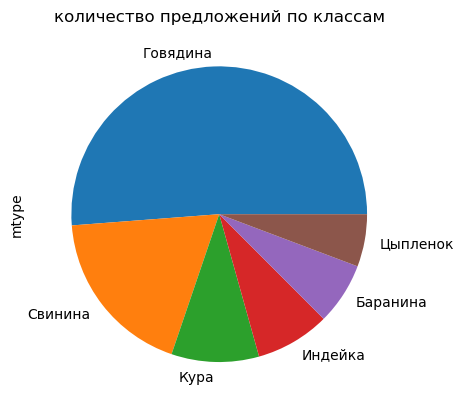

In [20]:
df['mtype'].value_counts().plot(kind='pie', title='количество предложений по классам');

#### рассмотрим длину текстов в корпусе

In [21]:
df['length'] = df['text'].apply(lambda x: len(x))
# добавим столбец с 

In [22]:
df['length'].describe()

count    16457.000000
mean       125.421644
std        285.520270
min          2.000000
25%         37.000000
50%         54.000000
75%        127.000000
max      18093.000000
Name: length, dtype: float64

<AxesSubplot:>

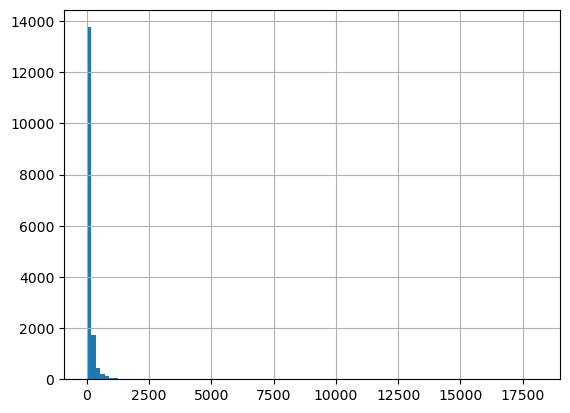

In [23]:
df['length'].hist(bins=100)

В корпусе присутствуют значимые выбросы по длине текста. Рассмотрим ближе:

<AxesSubplot:>

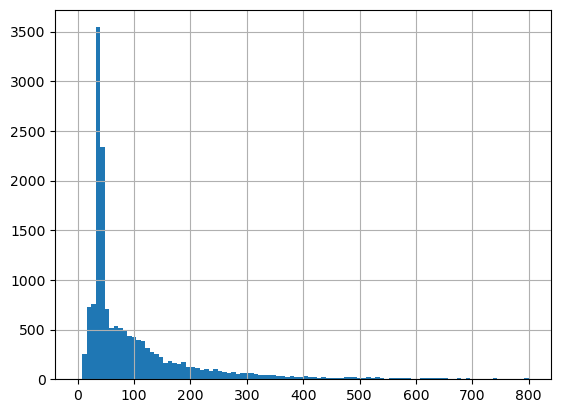

In [24]:
df['length'].hist(bins=100, range = [0, 800]);

In [25]:
print(len(df[df['length']>300]['text'].values)/len(df))

0.08142431791942638


У нас всего 8% текстов длиннее 300 символов. Их можно будет удалить в качестве выбросов.

Ниже рассмотрим подозрительно короткие тексты:

In [26]:
print(df[df['length']<15]['text'].values)

['Бедро индейки' 'Бедро куриное' 'Бедро Курное' 'Бедро ц/б' 'Бедро ЦБ'
 'Бедро ЦБ ГОСТ' 'Бедро ЦБ ТУ' 'Говядина б/к' 'Вымя -30 руб.' 'Вымя Вымя'
 'Вымя говяжье' 'Вырезка гов' 'вырезка свиная' 'Глазной мускул'
 'Голень индейки' 'Голень куриный' 'Голень ЦБ 80' 'говяжьи головы'
 'Голов индейки' 'Голова свиная' 'Головы говяжьи' 'Головы свинные'
 'Головы свиные' 'Голяшка свиная' 'Грудка н/к' 'Грудка ЦБ охл'
 'Грудку Куриную' 'Гузка Индейки' 'Гузка ц/б' 'Гузки индейки'
 'Говядина гуляш' 'Говядина жилка' 'Баранина жир' 'говядина жир'
 'шкура куриная' 'Баранина кости' 'говяжьи лытки' 'Блоки говяжьи'
 'Говядина ноги' 'Говядина ножки' 'печень говяжья' '  ' 'БЫКИ В П/Т'
 'Говядина 170р' 'Говядина почки' 'Говядина рагу' 'Говядина рубцы'
 'Говяжье сердце' 'Баранина Тзб' 'Говядина ТЗЧ.' 'Баранина туши'
 'Говядина туша' 'Говядина уши' 'Говядина хвост' 'Говядина шея'
 'Говядина щека' 'бараний язык' 'Говядина язык' 'Говяжий язык'
 'желудок свиной' 'Жилка гов.' 'Жилка говяжья' 'Жилку говяжью'
 'Жир говя

Как видно из полученного списка, короткие тексты не содержат ошибок.

In [27]:
df = df.drop(df[df.loc[:,'length']>300].index)
# удаление выбросов

Ниже рассмотрим длину оставшихся текстов:

In [28]:
df['length'].describe()

count    15117.000000
mean        78.551366
std         62.171346
min          2.000000
25%         36.000000
50%         47.000000
75%        105.000000
max        300.000000
Name: length, dtype: float64

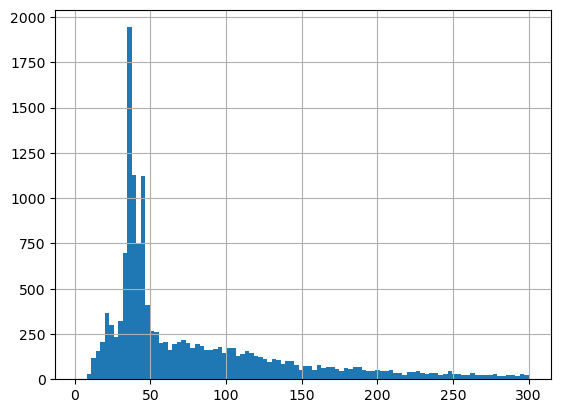

In [237]:
df['length'].hist(bins=100);

Большинство сохранившихся текстов содержат в районе 25-50 символов.

### Подготовка текста

#### Приведение к нижнему регистру, удаление незначимых слов и символов.

In [30]:
corpus = df['text'].astype('U')
# приведение текстов к юникоду

In [31]:
corpus = corpus.apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', ' ',x))
# оставляем только кириллические буквы, прочие символы заменяем пробелами

In [32]:
corpus = corpus.apply(lambda x: x.lower())
# приводим к нижнему регистру

In [33]:
corpus = corpus.apply(lambda x: x.replace('руб',''))
corpus = corpus.apply(lambda x: x.replace('цена',''))
corpus = corpus.apply(lambda x: x.replace('гост',''))
corpus = corpus.apply(lambda x: x.replace('охл',''))
corpus = corpus.apply(lambda x: x.replace('зам',''))

# слова, имеющие отношение к цене и виду продукции - охлажденной, замороженной - не имеют отношения к видовой
# принадлежности сырья - соответственно, можно удалить их.

In [34]:
corpus = corpus.apply(lambda x: " ".join(x.split()))
# убираем лишние пробелы, в т.ч. полученные в результате обработки

In [35]:
corpus

0                          частей баранина частей баранина
1                                          баранина частей
2                                          баранина частей
3                                          баранина частей
4                                          баранина частей
                               ...                        
17816                           цыпленок четвертина задняя
17817                           цыпленок четвертина задняя
17818    цб шеи п ф свеженка пак шеи куриные позц свеже...
17819                                цыпленок шея без кожи
17820                                цыпленок шея без кожи
Name: text, Length: 15117, dtype: object

#### Токенизация

Используем BertTokenizer, предварительно обученный на русском языке.

In [36]:
tokenizer = transformers.BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
# предобученный токенизатор Bert

In [37]:
%%time
corpus = corpus.apply(lambda x: tokenizer.encode(x))
# применение токенизатора

Wall time: 6.65 s


In [38]:
corpus
# осмотр полученных значений

0        [101, 15021, 93973, 2889, 15021, 93973, 2889, ...
1                           [101, 93973, 2889, 15021, 102]
2                           [101, 93973, 2889, 15021, 102]
3                           [101, 93973, 2889, 15021, 102]
4                           [101, 93973, 2889, 15021, 102]
                               ...                        
17816    [101, 90378, 13286, 28048, 29295, 2058, 61184,...
17817    [101, 90378, 13286, 28048, 29295, 2058, 61184,...
17818    [101, 885, 844, 50610, 871, 881, 76676, 22799,...
17819    [101, 90378, 13286, 28048, 84725, 4428, 25983,...
17820    [101, 90378, 13286, 28048, 84725, 4428, 25983,...
Name: text, Length: 15117, dtype: object

Как видно выше, тексты токенизированы.
#### Padding
Добавим нули в конце полученных векторов для выравнивания их длины: это необходимо для дальнейшей работы RuBert. 

In [39]:
length = pd.Series(corpus.apply(lambda x: len(x))).max() 
# определяем максимальную длину полученных векторов

In [40]:
length

75

In [41]:
corpus = corpus.apply(lambda x: x + [0]*(length - len(x))) 
# padding с помощью нулей

In [42]:
corpus = corpus.apply(lambda x: np.array(x))
# переводим список в тип np.array

In [43]:
attention_mask = corpus.apply(lambda x: np.where(np.array(x)!= 0, 1, 0))
print(attention_mask.shape)
# готовим для модели маску, показывающую что нули не имеют смыслового значения

(15117,)


#### Создание эмбеддингов с помощью RuBERT

In [45]:

model = transformers.BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

# загружаем предобученную BertModel

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
# batch - чтоб модель одновременно строила заданное количество векторов
batch_size = 100





In [47]:
corpus = corpus.values
# переводим в тип np.array

In [48]:
corpus = np.stack(corpus)
# переводим в двумерный массив

In [49]:
corpus.shape

(15117, 75)

In [50]:
attention_mask = np.stack(attention_mask.values)
# маску также переводим в двумерный массив

In [51]:
embeddings = []
# сделаем пустой список для хранения эмбеддингов

for i in notebook.tqdm(range(corpus.shape[0] // batch_size)): # это позволит вывести progress bar в процессе работы модели
    # преобразуем каждый батч методом torch.LongTensor
    batch = torch.LongTensor(corpus[batch_size*i:batch_size*(i+1)])
    # то же самое  делаем с маской
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad(): # модель предобучена, no_grad() позволяет не обучать модель
        # сохраняем вывод модели после того как ей "скормили" batch и маску
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    # полученный результат переводим в array и добавляем в список embeddings
    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

  0%|          | 0/151 [00:00<?, ?it/s]

In [52]:
features = np.concatenate(embeddings)
# переводим список в двумерный массив

In [54]:
features.shape
# из-за размера батча потерялось 17 записей

(15100, 768)

In [60]:
pd.DataFrame(features).to_csv('features_backup.csv')
# учитывая, что получение этих данных заняло много времени, сохраним их в файл

In [ ]:
# здесь команда для восстановления features при необходимости
# features = pd.read_csv('features_backup.csv').drop('Unnamed: 0', axis=1)

In [58]:
df = df[:-17]
# убираем 17 пропавших в features записей с конца

In [57]:
df[:-17]
# проверяем размер

,text,mtype,length
0,12 частей баранина 12 частей баранина,Баранина,38
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина,39
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина,39
3,"Баранина, 12 частей, охл.",Баранина,25
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина,39
...,...,...,...
17799,"Цыпленок, филе бедра, с кожей цена 210 руб.",Цыпленок,43
17800,Филе (ЦБ) грудки ******Предлагаем продукци...,Цыпленок,204
17801,Филе грудки (ГОСТ) АКЦИЯ от ООО МИКПРОМ. На ...,Цыпленок,144
17802,Филе грудки ГОСТ монолит 185 руб. Мясоперера...,Цыпленок,231


### Подготовка целевого признака

In [61]:
# с целью классификации целевой признак будет закодирован в числовом виде
encoder = OrdinalEncoder()
df['Target'] = encoder.fit_transform(df['mtype'].values.reshape(-1,1))

C:\Users\Acer\AppData\Local\Temp\ipykernel_2868\1585434683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = encoder.fit_transform(df['mtype'].values.reshape(-1,1))


In [62]:
classes = pd.Series(np.array(encoder.categories_).reshape(-1,1)[:,0])
# сохраним классы с номерами for future reference

In [64]:
# создаем переменную с целевым признаком
target = df['Target']

### Разделение обучающей и тестовой выборок

In [66]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.20, random_state=13)
# разделяем обучающую и тестовую выборки в соотношении, взятом из требований к проекту

## Обучение моделей

### LGBMClassifier()

In [75]:
# задаем решетку параметров
lgbm_grid = {
             'max_depth':[3, 8, 15],
             'n_estimators':[20, 50, 90, 150],
             'num_leaves':[11, 21, 31, 41],
             'class_weight':['balanced'],
             'random_state':[13],
             'objective':['multiclass']
            }

In [77]:
# создаем экземпляр GridSearchCV с LGBM классификатором в качестве estimator
lgbm_cv = GridSearchCV(
                        estimator=LGBMClassifier(),
                        verbose=3,
                        param_grid=lgbm_grid,
                        cv=3,
                        scoring='accuracy',
                        n_jobs=-1)

In [78]:
# обучаем модель и выводим результаты кросс-валидации
%%time
lgbm_cv.fit(features_train, target_train)
print(lgbm_cv.best_score_)
print(lgbm_cv.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.8259099768399699
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 150, 'num_leaves': 21, 'objective': 'multiclass', 'random_state': 13}
Wall time: 56min 56s


#### Оценка важности признаков
Вероятно, не все из полученных фичей имеют значение для модели. Попробуем разобраться, какие можно удалить и что из этого получится.

In [80]:
lgbm_importances = permutation_importance(lgbm_cv, features_train, target_train, random_state=13, scoring='accuracy')
# методом permutation importance получаем данные о важности признаков

In [108]:
lgbm_importances = lgbm_importances.importances_mean

In [111]:
lgbm_importances = pd.Series(lgbm_importances)

In [158]:
lgbm_importances.describe()
# осматриваем, какой разброс значений mean importances

count    768.000000
mean       0.000013
std        0.000041
min       -0.000050
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000480
dtype: float64

In [156]:
# как видно, большая часть признаков не обладает ценностью для данной модели.
# выберем наиболее важные признаки
chosen_indices = lgbm_importances[lgbm_importances>0.0001].index

In [159]:
len(chosen_indices)

23

In [160]:
features_lgbm = pd.DataFrame(features_train)

In [161]:
features_lgbm = features_lgbm[chosen_indices]
# оставлям только фичи из колонок, соответствующих chosen indices

In [162]:
features_lgbm.shape

(12080, 23)

#### Повторное обучение с учетом важности признаков

In [169]:
lgbm_grid = {
             'max_depth':[15,20],
             'n_estimators':[450, 500, 550],
             'num_leaves':[41, 51],
             'class_weight':['balanced'],
             'random_state':[13],
             'objective':['multiclass']
            }
# данные параметры получены в процессе длительного перебора

In [170]:
lgbm_cv = GridSearchCV(
                        estimator=LGBMClassifier(),
                        verbose=3,
                        param_grid=lgbm_grid,
                        cv=3,
                        scoring='accuracy',
                        n_jobs=-1)

In [171]:
%%time
lgbm_cv.fit(features_lgbm, target_train)
print(lgbm_cv.best_score_)
print(lgbm_cv.best_params_)

# выводим лучшие параметры и лучшее значение accuracy

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.7382449678447595
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 450, 'num_leaves': 41, 'objective': 'multiclass', 'random_state': 13}
Wall time: 5min 36s


LGBMClassifier не дал удовлетворительных результатов для данной задачи

### Логистическая регрессия

In [67]:
log_pipeline = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression())])
# создаем пайплайн с объектом standard scaler во избежание утечки целевого признака при кросс-валидации

In [68]:
log_grid = {'log__random_state':[13],
           'log__class_weight':['balanced'],
           'log__solver':['lbfgs', 'newton-cg', 'sag', 'saga']}

In [71]:
log_cv = GridSearchCV(
                        estimator=log_pipeline,
                        verbose=3,
                        param_grid=log_grid,
                        cv=3,
                        scoring='accuracy',
                        n_jobs=-1)

In [72]:
log_cv.fit(features_train, target_train)
print(log_cv.best_score_)
print(log_cv.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.8542218317464911
{'log__class_weight': 'balanced', 'log__random_state': 13, 'log__solver': 'saga'}


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### Оценка важности признаков

In [81]:
# повторяем те же действия по отбору важных признаков, что с предыдущей моделью
%%time
log_importances = permutation_importance(log_cv, features_train, target_train, random_state=13, scoring='accuracy')

In [145]:
log_importances = pd.Series(log_importances.importances_mean)

In [146]:
log_importances.describe()

count    768.000000
mean       0.001037
std        0.001301
min       -0.001440
25%        0.000132
50%        0.000786
75%        0.001743
max        0.008013
dtype: float64

In [173]:
chosen_indices = log_importances[log_importances>0.001].index

In [175]:
chosen_indices

Int64Index([  6,   9,  10,  11,  13,  21,  23,  25,  26,  27,
            ...
            751, 754, 756, 758, 759, 761, 762, 763, 766, 767],
           dtype='int64', length=324)

In [176]:
features_log = pd.DataFrame(features_train)[chosen_indices]

In [177]:
features_log.shape

(12080, 324)

In [178]:
%%time
log_cv.fit(features_log, target_train)
print(log_cv.best_score_)
print(log_cv.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Acer\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8409767230656556
{'log__class_weight': 'balanced', 'log__random_state': 13, 'log__solver': 'saga'}
Wall time: 1min 54s


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Логистическая регрессия с использованием StandardScaler сочтена оптимальной моделью.
## Тестирование лучшей модели

### Проверка на тестовой выборке

In [180]:
features_log_test = pd.DataFrame(features_test)[chosen_indices]
# отбираем из тестовой выборки нужные фичи

In [183]:
accuracy_score(target_test, log_cv.predict(features_log_test))
# получаем значение accuracy

0.8337748344370861

В процессе работы удалось достичь значения метрики accuracy 0.83 при использовании логистической регрессии со следующими параметрами: {'log__class_weight': 'balanced', 'log__random_state': 13, 'log__solver': 'saga'}. Входные данные при этом были обработаны с помощью StandardScaler().

### Проверка на образцах из тех. задания

In [204]:
# создаем переменную с образцами из тех. задания
text = pd.Series(['Говядина блочная 2 сорт в наличии ООО \"АгроСоюз\" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.',
'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:', 'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'])

In [205]:
text

0    Говядина блочная 2 сорт в наличии ООО "АгроСою...
1    Куриная разделка Продам кур и куриную разделку...
2    Говяжью мукозу Продам говяжью мукозу в охл и з...
dtype: object

In [206]:
text = text.astype('U')
# приведение текстa к юникоду
text = text.apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', ' ',x))
# оставляем только кириллические буквы, прочие символы заменяем пробелами
text = text.apply(lambda x: x.lower())
# приводим к нижнему регистру
text = text.apply(lambda x: x.replace('руб',''))
text = text.apply(lambda x: x.replace('цена',''))
text = text.apply(lambda x: x.replace('гост',''))
text = text.apply(lambda x: x.replace('охл',''))
text = text.apply(lambda x: x.replace('зам',''))

# слова, имеющие отношение к цене и виду продукции - охлажденной, замороженной - не имеют отношения к видовой
# принадлежности сырья - соответственно, можно удалить их.
text = text.apply(lambda x: " ".join(x.split()))
# убираем лишние пробелы, в т.ч. полученные в результате обработки

In [207]:
# токенизация
text = text.apply(lambda x: tokenizer.encode(x))

In [208]:
# выравнивание длины векторов
text = text.apply(lambda x: x + [0]*(length - len(x)))

In [210]:
# создание маски
mask = text.apply(lambda x: np.where(np.array(x)!= 0, 1, 0))
print(mask.shape)

(3,)


In [213]:
text = np.stack(text.values)
mask = np.stack(mask.values)
# переводим текст и маску в двумерный массив

In [217]:
# создание эмбеддингов

# val_emb будет содержать текст, преобразованный с помощью LongTensor()
val_emb = torch.LongTensor(text)
# mask_emb будет содержать аналогично преобразованную маску
mask_emb = torch.LongTensor(mask)
with torch.no_grad(): # модель не дообучается
    emb = model(val_emb, attention_mask=mask_emb) # сохраняем результат работы модели


In [230]:
emb = emb[0][:,0,:].numpy()
# переводим результат в двумерный массив

In [231]:
emb = pd.DataFrame(emb)[chosen_indices]
# выбираем нужные фичи из результата

In [233]:
log_cv.predict(emb)
# получаем предсказания

array([1., 3., 1.])

In [234]:
classes
# выводим классы чтоб сравнить результат

0    Баранина
1    Говядина
2     Индейка
3        Кура
4     Свинина
5    Цыпленок
dtype: object

- Образцы:
    - Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.

    - Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:

    - Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.
   
- Предсказанные классы:
    - говядина
    - кура
    - говядина
    
Таким образом, предложенный метод позволил верно классифицировать предложенные заказчиком образцы.

## Вывод

### Цель работы:
Построить модель машинного обучения для классификации продукции по текстовому описанию.
### Материалы и методы:
- Работа выполнена на датасете, предоставленном заказчиком, содержащем описание продукции и ее класс.
- В работе применялись средства Python, библиотек Pandas, NumPy, re, tqdm. Задачи машинного обучения решались с помощью torch, transformers, sklearn, lightgbm.

### Ход выполнения проекта:
- удалены пропуски и выбросы в данных;
- текст очищен и токенизирован;
- построены эмбеддинги;
- выбраны наиболее значимые обучающие признаки;
- на полученных данных обучены модели классификации LGBMClassifier и LogisticRegression;
- оптимальная модель проверена на тестовой выборке и на образцах, полученных от заказчика.

### Результат работы:
Предложен метод классификации товара по текстовому описанию, включающий следующие этапы:
- очистка от выбросов и подготовка текста;
- токенизация с помощью BertTokenizer;
- создание эмбеддингов средствами PyTorch и BERT;
- классификация с помощью LogisticRegression.

Данный метод показал значение accuracy 0.83 на тестовой выборке.
Образцы данных заказчика классифицированы верно в 3 случаях их 3.